# Comparing ensemble models

In this notebook, we assess three ensemble models (AdaBoost, Extremely Randomized Trees, and Random Forests) and the CART model into a regression problem: to predict a sales price for houses given $79$ input variables. We use a manipulated data, which categorical were transformed into numerical, and missing values were already estimated. Therefore, the data is only numeric without missing values.

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
np.random.seed(38)

### Loading data

In [3]:
df = pd.read_csv('data/manipulated_train.csv')

In [4]:
df.shape

(1460, 80)

In [5]:
df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,SalePrice
0,4.110874,65.0,9.042040,7,1.791759,7.602900,7.602900,5.283204,6.561031,0.0,...,2,5,5,2,3,4,1,8,4,12.247699
1,3.044522,80.0,9.169623,6,2.197225,7.589336,7.589336,0.000000,6.886532,0.0,...,2,5,5,2,3,4,1,8,4,12.109016
2,4.110874,68.0,9.328212,7,1.791759,7.601902,7.602401,5.093750,6.188264,0.0,...,2,5,5,2,3,4,1,8,4,12.317171
3,4.262680,60.0,9.164401,7,1.791759,7.557995,7.586296,0.000000,5.379897,0.0,...,3,5,5,2,3,4,1,8,0,11.849405
4,4.110874,84.0,9.565284,8,1.791759,7.601402,7.601402,5.860786,6.486161,0.0,...,2,5,5,2,3,4,1,8,4,12.429220


In [6]:
df.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,3.818794,57.623288,9.110966,6.099315,1.869266,7.586821,7.593756,2.120264,4.229731,0.655398,...,1.876712,4.716438,4.763014,1.856164,2.991096,3.504795,1.069178,7.513014,3.770548,12.024057
std,0.688354,34.664304,0.517369,1.382997,0.168400,0.015389,0.010424,2.628759,2.992052,1.845045,...,1.191646,0.898787,0.802670,0.496592,0.140703,1.082912,0.372102,1.552100,1.100854,0.399449
min,3.044522,0.000000,7.170888,1.000000,0.693147,7.535297,7.576097,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.460271
25%,3.044522,42.000000,8.929898,5.000000,1.791759,7.578145,7.584773,0.000000,0.000000,0.000000,...,1.000000,5.000000,5.000000,2.000000,3.000000,4.000000,1.000000,8.000000,4.000000,11.775105
50%,3.931826,63.000000,9.156887,6.000000,1.791759,7.587817,7.598399,0.000000,5.951943,0.000000,...,2.000000,5.000000,5.000000,2.000000,3.000000,4.000000,1.000000,8.000000,4.000000,12.001512
75%,4.262680,79.000000,9.358976,7.000000,1.945910,7.601402,7.603399,5.107456,6.569832,0.000000,...,3.000000,5.000000,5.000000,2.000000,3.000000,4.000000,1.000000,8.000000,4.000000,12.273736
max,5.252273,313.000000,12.279537,10.000000,2.302585,7.606387,7.606387,7.378384,8.638525,7.296413,...,3.000000,5.000000,5.000000,2.000000,3.000000,4.000000,4.000000,8.000000,5.000000,13.534474


In [7]:
X = df.drop(['SalePrice'], axis=1)

In [8]:
y = df['SalePrice']

## Learning from data

In this section, we estimate the $R^2$ score of each regression technique (without tuning the algorithm hyperparameters). Remembering that such score is bounded by $[0, 1]$, in which the closer to $1$ the better.

For more information: https://en.wikipedia.org/wiki/Coefficient_of_determination

In [9]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, ExtraTreesRegressor, RandomForestRegressor

In [10]:
from sklearn.model_selection import cross_val_score

### CART

In [11]:
cart = DecisionTreeRegressor(random_state=38)

In [12]:
cart.get_params()

{'criterion': 'mse',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_split': 1e-07,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': 38,
 'splitter': 'best'}

In [13]:
cross_val_score(cart, X, y, cv=10, n_jobs=4)

array([ 0.73466462,  0.80476365,  0.78590864,  0.752134  ,  0.79370207,
        0.81923448,  0.7675584 ,  0.69316781,  0.76547185,  0.74989849])

In [14]:
cart.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=38,
           splitter='best')

### Extra-Trees

In [15]:
et = ExtraTreesRegressor(n_estimators=100, random_state=38)

In [16]:
et.get_params()

{'bootstrap': False,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_split': 1e-07,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': 38,
 'verbose': 0,
 'warm_start': False}

In [17]:
cross_val_score(et, X, y, cv=10, n_jobs=4)

array([ 0.89304246,  0.90905688,  0.90012333,  0.83713641,  0.85506537,
        0.89329263,  0.89250451,  0.89771885,  0.87403396,  0.87313528])

### Adaboost

In [18]:
adaboost = AdaBoostRegressor(n_estimators=100, random_state=38)

In [19]:
adaboost.get_params()

{'base_estimator': None,
 'learning_rate': 1.0,
 'loss': 'linear',
 'n_estimators': 100,
 'random_state': 38}

In [20]:
cross_val_score(adaboost, X, y, cv=10, n_jobs=4)

array([ 0.77034315,  0.82299502,  0.8571476 ,  0.81305816,  0.8212515 ,
        0.78971344,  0.82164521,  0.81345948,  0.73552948,  0.80973389])

### RandomForest

In [21]:
rf = RandomForestRegressor(random_state=38, n_estimators=100)

In [22]:
rf.get_params()

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_split': 1e-07,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': 38,
 'verbose': 0,
 'warm_start': False}

In [23]:
cross_val_score(rf, X, y, cv=10, n_jobs=4)

array([ 0.84571599,  0.90515093,  0.89883205,  0.84288504,  0.86559795,
        0.90210988,  0.87950666,  0.89694963,  0.86052263,  0.85167737])

## Model statistics

In this section, we extract some model information, such as:
* forest statistics: the number of nodes, leaf nodes, and depth of each ensemble model;
* feature importances: the top $10$ features considered by each model;
* prediction correlation: we predict sales prices for unseen data by every model, and correlate such values.

In [24]:
for regr in [et, adaboost, rf]:
    regr.fit(X, y)

#### Forest statistics

In [25]:
from unveil_tree_structure import *

In [26]:
for regr in [et, adaboost, rf]:
    forest_stats = pd.DataFrame([ obtain_tree_details(estimator.tree_) for estimator in regr.estimators_ ])
    forest_stats.columns = 'num_nodes leaf_nodes depth'.split()
    print(forest_stats.describe())

         num_nodes   leaf_nodes       depth
count   100.000000   100.000000  100.000000
mean   2831.320000  1416.160000   25.310000
std      10.744865     5.372432    1.894676
min    2805.000000  1403.000000   22.000000
25%    2823.000000  1412.000000   24.000000
50%    2831.000000  1416.000000   25.000000
75%    2839.000000  1420.000000   26.000000
max    2859.000000  1430.000000   32.000000
       num_nodes  leaf_nodes  depth
count      100.0       100.0  100.0
mean        15.0         8.0    3.0
std          0.0         0.0    0.0
min         15.0         8.0    3.0
25%         15.0         8.0    3.0
50%         15.0         8.0    3.0
75%         15.0         8.0    3.0
max         15.0         8.0    3.0
         num_nodes  leaf_nodes       depth
count   100.000000  100.000000  100.000000
mean   1759.480000  880.240000   22.350000
std      25.991638   12.995819    2.451036
min    1693.000000  847.000000   19.000000
25%    1741.000000  871.000000   20.000000
50%    1759.000000  88

#### Feature importances

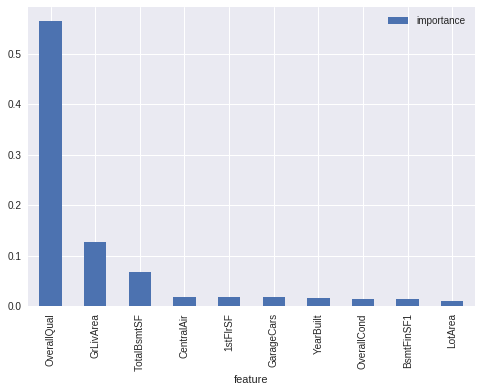

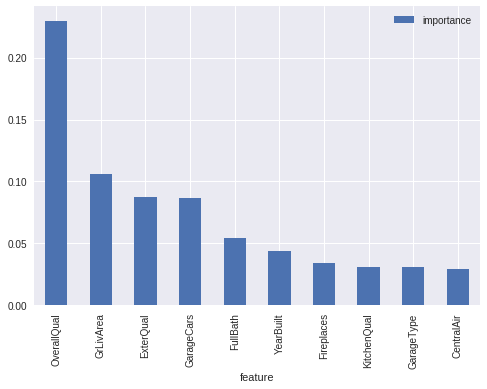

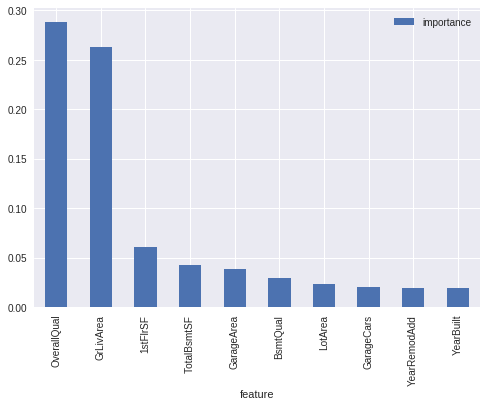

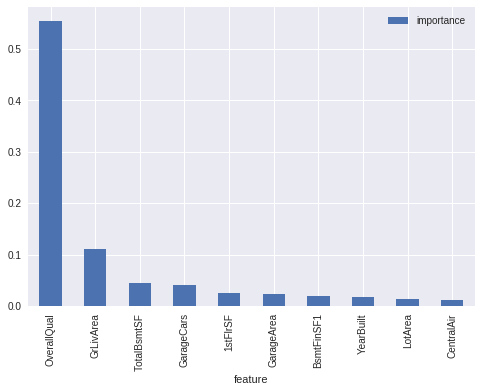

In [27]:
for regr in [cart, et, adaboost, rf]:
    res = pd.DataFrame({'feature': X.columns, 'importance': regr.feature_importances_})
    res.sort_values(['importance'], ascending=False).head(10).plot.bar(x='feature')
plt.show()

#### Correlation among predictions

In [28]:
df = pd.read_csv('data/manipulated_test.csv')

In [29]:
df.shape

(1459, 79)

In [30]:
X_unseen = df

In [31]:
preds = np.zeros((df.shape[0], 4), np.float16)

for idx, regr in enumerate([cart, et, adaboost, rf]):
    preds[:, idx] = regr.predict(X_unseen)

In [32]:
preds_df = pd.DataFrame(preds)
preds_df.columns = ['CART', 'ExtraTrees', 'AdaBoost', 'RandomForest']

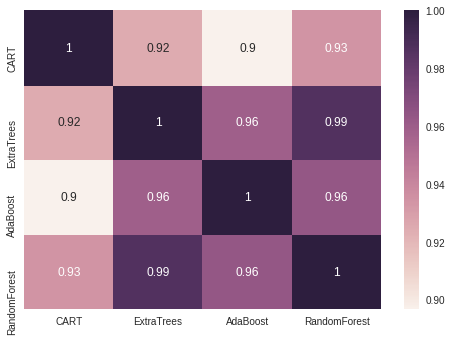

In [33]:
sns.heatmap(preds_df.corr(), annot=True)
plt.show()